In [11]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
import math
import quandl
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")
%matplotlib inline

from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression

In [12]:
# quandl.ApiConfig.api_key = ''

# load Google Stock data
df = quandl.get('WIKI/GOOGL')

df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000,0,1,50.159839,52.191109,48.128568,50.322842,44659000
2004-08-20,101.01,109.08,100.50,108.310,22834300,0,1,50.661387,54.708881,50.405597,54.322689,22834300
2004-08-23,110.76,113.48,109.05,109.400,18256100,0,1,55.551482,56.915693,54.693835,54.869377,18256100
2004-08-24,111.24,111.60,103.57,104.870,15247300,0,1,55.792225,55.972783,51.945350,52.597363,15247300
2004-08-25,104.76,108.00,103.88,106.000,9188600,0,1,52.542193,54.167209,52.100830,53.164113,9188600


In [13]:
# High-low percentage
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100

# Percentage change ((new - old) / old * 100)
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

# Define useful columns
columns = [
    'Adj. Close',
    'Adj. Volume',
    'HL_PCT',
    'PCT_change',
]

df = df[columns]

df.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change
Date,,,,
2004-08-19,50.322842,44659000,3.712563,0.324968
2004-08-20,54.322689,22834300,0.710922,7.227007
2004-08-23,54.869377,18256100,3.729433,-1.227880
2004-08-24,52.597363,15247300,6.417469,-5.726357
2004-08-25,53.164113,9188600,1.886792,1.183658


In [14]:
forecast_col = 'Adj. Close'

# fill column to prevent missing data
df.fillna(-99999, inplace=True)

# amount of days in advance
forecast_out = int(math.ceil(0.01*len(df)))
forecast_out

32

In [15]:
# set the label to the shift of the forecast col
df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)
df.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label
Date,,,,,
2004-08-19,50.322842,44659000,3.712563,0.324968,69.399229
2004-08-20,54.322689,22834300,0.710922,7.227007,68.752232
2004-08-23,54.869377,18256100,3.729433,-1.227880,69.639972
2004-08-24,52.597363,15247300,6.417469,-5.726357,69.078238
2004-08-25,53.164113,9188600,1.886792,1.183658,67.839414


In [16]:
# X feature
# build up a dataset of everything expect the column label
X = np.array(df.drop(['label'], 1))

X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
# X = X[:-forecast_out]

df.dropna(inplace=True)

# y labels
# build dataset of only the column label
y = np.array(df['label'])

# Create the train and test set
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [17]:
clf = LinearRegression()
# Train the model
clf.fit(X_train, y_train)
# Test the accuracy
clf.score(X_test, y_test)

0.96946337451727072

In [18]:
forecast_set = clf.predict(X_lately)
forecast_set

array([ 793.75544303,  793.5260877 ,  787.64137252,  789.94775146,
        792.55729646,  797.90676021,  783.37116594,  772.00413339,
        773.06492319,  787.11397496,  784.57739569,  800.16749642,
        803.9847421 ,  818.16342608,  816.64628054,  823.05623077,
        826.15874724,  823.98191223,  817.89265984,  821.32670984,
        824.42624043,  821.29018428,  819.04046574,  817.10477086,
        818.48244881,  813.30003859,  812.10153131,  800.81699836,
        815.93608272,  816.49399724,  822.14117905,  833.32424316])

In [19]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df.head()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,Forecast
2004-08-19,50.322842,44659000,3.712563,0.324968,69.399229,NaN
2004-08-20,54.322689,22834300,0.710922,7.227007,68.752232,NaN
2004-08-23,54.869377,18256100,3.729433,-1.227880,69.639972,NaN
2004-08-24,52.597363,15247300,6.417469,-5.726357,69.078238,NaN
2004-08-25,53.164113,9188600,1.886792,1.183658,67.839414,NaN


In [20]:
df.tail()

,Adj. Close,Adj. Volume,HL_PCT,PCT_change,label,Forecast
2017-02-03,NaN,NaN,NaN,NaN,NaN,800.816998
2017-02-04,NaN,NaN,NaN,NaN,NaN,815.936083
2017-02-05,NaN,NaN,NaN,NaN,NaN,816.493997
2017-02-06,NaN,NaN,NaN,NaN,NaN,822.141179
2017-02-07,NaN,NaN,NaN,NaN,NaN,833.324243


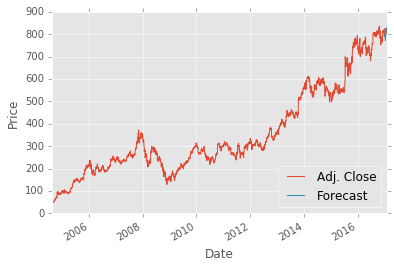

In [21]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()